In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
class Maximize(object):
    period = 30
    #np.random.seed(period)

    
    def __init__(self, n, rho, gamma):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        
        
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.hc_ = self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_

        
    def get_original_H(self, hc_mu, hc_sigma):
        dc_rate = np.exp((0.04 + 0.0 + 0.0) * (np.array(range(self.period)) + 1) * (-1))
        
        if self.period == 0:
            self.labor_income = np.zeros([self.n, self.period+1])
            self.H_t = np.zeros([self.n])
        else:
            self.labor_income = self.initial_income*np.cumprod(np.exp(hc_mu+hc_sigma*(self.rho * self.market_[:, :-1] + np.sqrt(1 - self.rho ** 2) * self.hc_[:, :-1])), axis=1)
            self.H_t = self.labor_income @ dc_rate
    
    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income

In [3]:
class Maximize_Calibraton(object):
    period = 30
    #np.random.seed(period)
    retirement_age = 60

    
    def __init__(self, n, rho, gamma, aggregate_risk):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        self.aggregate_risk = aggregate_risk
        
            
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.hc_ = self.aggregate_risk*(self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_)


    def get_calibration_H(self, fixed_effect_coeff, age_coeff_list):
        dc_rate = np.exp((0.04 + 0.0 + 0.0) * (np.array(range(self.period+1)) + 1) * (-1))
        age_list = np.array(list(range(self.retirement_age-(self.period+1), self.retirement_age)))

        after_retire_H_t = np.exp(fixed_effect_coeff) / (1-dc_rate[0])
        if self.period == 0:
            self.labor_income = np.exp(fixed_effect_coeff)
            self.H_t = after_retire_H_t
        else:
            ic_list = fixed_effect_coeff + (age_list * age_coeff_list[0]) + ((age_list**2 /10) * age_coeff_list[1]) + ((age_list**3/100) * age_coeff_list[2])
            self.labor_income = np.exp(np.array([ic_list]*self.n)  + self.hc_[:, :-1])
            self.H_t = self.labor_income @ dc_rate + (after_retire_H_t * dc_rate[-1])

    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income, retirement_age=60):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income
        self.retirement_age = retirement_age

In [4]:
def lc_asset_allocation(asset_dic, group_characherize_dic, sample_size=20000, gamma=4):
    np.random.seed(2)

    lc_weights = []
    lc_labor_income = []
    lc_wealth = []
    model = Maximize_Calibraton(n=sample_size, rho=group_characherize_data["rho"], gamma=gamma, aggregate_risk=group_characherize_data["aggregate_risk"])
    for i in range(35)[::-1]:

        if i is range(35)[::-1][0]:
            financial_wealth = group_characherize_data["initial_wealth"]
            income = group_characherize_data["initial_income"]
            model.change_parameters(i, financial_wealth, income)
        else:
            financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
            income = np.mean(model.labor_income[:, 0])
            model.change_parameters(i, financial_wealth, income)

        model.MC_data()
        model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
        model.get_asset_ret(market_mu=asset_data["risky"][0], market_sigma=asset_data["risky"][1], 
                            rf_mu=asset_data["rf"][0], rf_sigma=asset_data["rf"][1])
        opt_weights = model.fit()

        lc_weights.append(opt_weights)
        lc_labor_income.append(np.round(income))
        lc_wealth.append(np.round(financial_wealth))
        #print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))

        #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

    lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100
    lc_total_df = pd.DataFrame(np.array([lc_labor_income, lc_wealth]).T, index=range(35)[::-1], columns=["labor_income", "financial_wealth"])
    
    return lc_df, lc_total_df


def data_plotting(lc_total_df):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    ln1 = ax.plot(lc_total_df.index[::-1], lc_total_df.labor_income, color="b", label="labor_income")
    ax2 = ax.twinx()
    ln2 = ax2.plot(lc_total_df.index[::-1], lc_total_df.financial_wealth, color="r", linestyle="--", label="financial_wealth")

    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)

    plt.show()
    

def lc_weights_plot(lc_df):
    plt.figure(figsize=(10, 5))
    plt.fill_between(lc_df.index, lc_df["risky_asset"])
    plt.fill_between(lc_df.index, lc_df["risky_asset"], 100)
    plt.legend(["risky_asset", "risk_free"])
    plt.ylim(0, 100)
    plt.show()

In [5]:
asset_data = {"risky": [0.12, 0.35], "rf":[0.04, 0.03]}

## High_school edu levels
_______________

In [6]:
group_characherize_data = {"rho":0.633465, "aggregate_risk":np.sqrt(0.174855+0.005461), 
                           "fixed_effect_coeff":[7.5072-0.7417+0.3198+0.059*2], "age_coeff_list":[0.0124, 0.0064, -0.0009], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.5072-0.7417+0.3198+0.059*2 + (25 * 0.0124 + ((25**2 /10) *0.0064) + ((25**3/100) * -0.0009)))}

In [7]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=8)

In [8]:
lc_weights

,risky_asset,risk_free
0,100.00,0.00
1,100.00,0.00
2,100.00,0.00
3,100.00,0.00
4,100.00,0.00
5,100.00,0.00
6,89.08,10.92
7,72.23,27.77
8,60.76,39.24
9,54.96,45.04


In [9]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2375.0,2613.0,2670.0,2744.0,2812.0,2885.0,2962.0,3053.0,3116.0,3216.0,...,4347.0,4406.0,4438.0,4463.0,4464.0,4516.0,4536.0,4505.0,4501.0,4510.0
financial_wealth,1000.0,2281.0,3933.0,6042.0,8748.0,12200.0,16652.0,21971.0,27629.0,33846.0,...,262417.0,289769.0,319027.0,351478.0,386226.0,424501.0,466198.0,511284.0,560693.0,613720.0


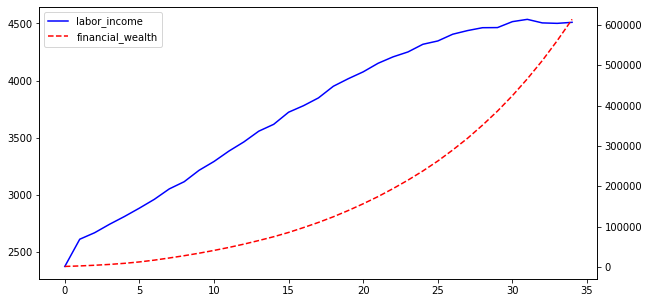

In [10]:
data_plotting(lc_data)

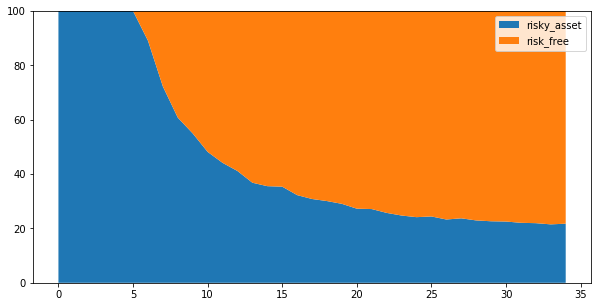

In [11]:
lc_weights_plot(lc_weights)

## College edu levels
_______________

In [12]:
group_characherize_data = {"rho":0.334903, "aggregate_risk":np.sqrt(0.145682+0.010166), 
                           "fixed_effect_coeff":[7.8016-2.3326+0.2550+0.0537*2], "age_coeff_list":[0.1232, -0.0193, 0.0011], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8016-2.3326+0.2550+0.0537*2 + (25 * 0.1232 + ((25**2 /10) * -0.0193) + ((25**3/100) * 0.0011)))}

In [13]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=6)

In [14]:
lc_weights

,risky_asset,risk_free
0,100.00,0.00
1,100.00,0.00
2,100.00,0.00
3,100.00,0.00
4,100.00,0.00
5,100.00,0.00
6,100.00,0.00
7,100.00,0.00
8,82.04,17.96
9,72.20,27.80


In [15]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2636.0,2861.0,2983.0,3123.0,3246.0,3377.0,3501.0,3642.0,3757.0,3893.0,...,5460.0,5552.0,5617.0,5676.0,5715.0,5815.0,5904.0,5917.0,5977.0,6077.0
financial_wealth,1000.0,2376.0,4173.0,6493.0,9485.0,13323.0,18287.0,24732.0,32830.0,41930.0,...,427016.0,477425.0,532010.0,593516.0,660276.0,735031.0,817556.0,908116.0,1008766.0,1118291.0


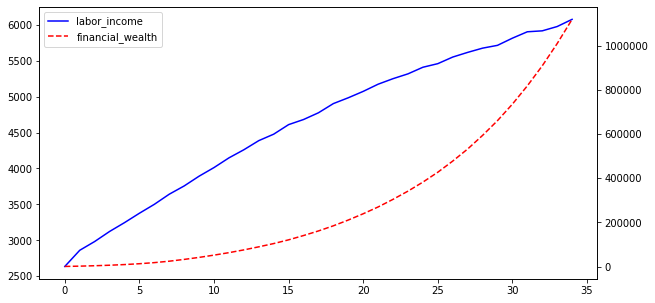

In [16]:
data_plotting(lc_data)

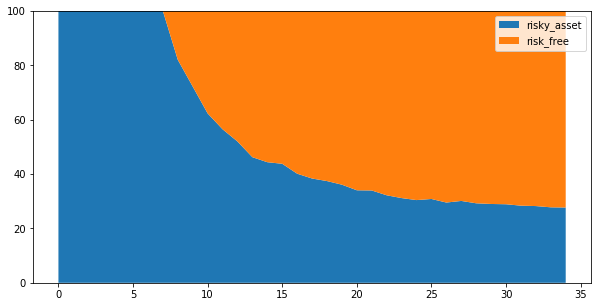

In [17]:
lc_weights_plot(lc_weights)

## University edu levels
_______________

In [18]:
group_characherize_data = {"rho":-0.010961, "aggregate_risk":np.sqrt(0.141262+0.005379), 
                           "fixed_effect_coeff":[7.8717-2.3055+0.3841+0.0440*2], "age_coeff_list":[0.1055, -0.0111, 0.0001], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.8717-2.3055+0.3841+0.0440*2 + (25 * 0.1055 + ((25**2 /10) * -0.0111) + ((25**3/100) * 0.0001)))}

In [19]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=6)

In [20]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2974.0,3206.0,3366.0,3545.0,3700.0,3872.0,4027.0,4204.0,4365.0,4529.0,...,6207.0,6241.0,6247.0,6226.0,6187.0,6183.0,6178.0,6072.0,6003.0,5970.0
financial_wealth,1000.0,2508.0,4489.0,7055.0,10372.0,14637.0,20159.0,27336.0,36368.0,46981.0,...,497781.0,556654.0,620443.0,692288.0,770272.0,857591.0,953982.0,1059780.0,1177319.0,1305240.0


In [21]:
lc_weights

,risky_asset,risk_free
0,100.00,0.00
1,100.00,0.00
2,100.00,0.00
3,100.00,0.00
4,100.00,0.00
5,100.00,0.00
6,100.00,0.00
7,100.00,0.00
8,87.19,12.81
9,75.98,24.02


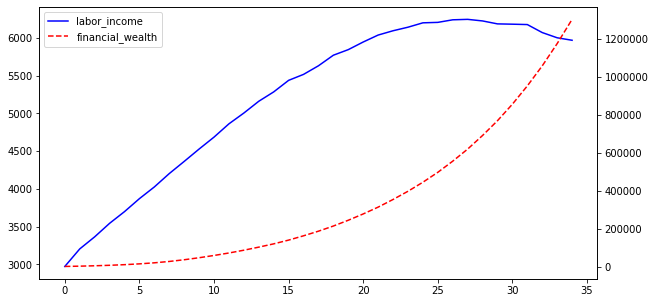

In [22]:
data_plotting(lc_data)

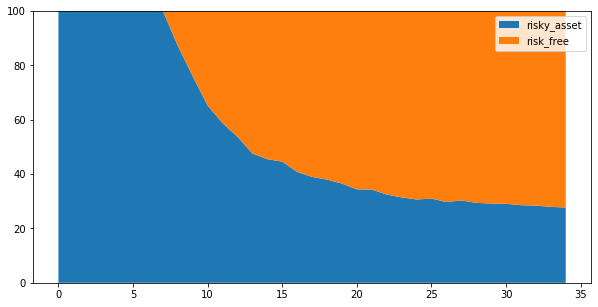

In [23]:
lc_weights_plot(lc_weights)

employ&univer

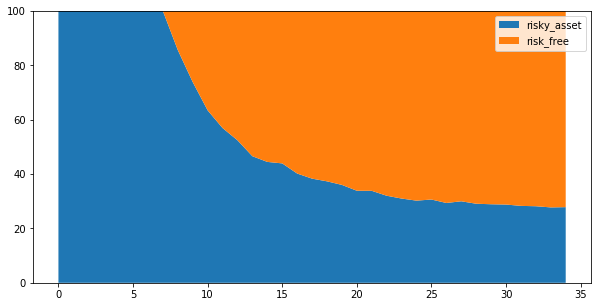

In [28]:
group_characherize_data = {"rho":0.8322, "aggregate_risk":np.sqrt(0.110894+0.005373), 
                           "fixed_effect_coeff":[7.915176-1.868544+0.394303+0.031684*2], "age_coeff_list":[0.066751, -0.000764, -0.000710], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.915176-1.868544+0.394303+0.031684*2 + (25 * 0.066751 + ((25**2 /10) * -0.000764) + ((25**3/100) * -0.000710)))}

lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=6)

lc_weights_plot(lc_weights)

In [29]:
lc_weights

,risky_asset,risk_free
0,100.00,0.00
1,100.00,0.00
2,100.00,0.00
3,100.00,0.00
4,100.00,0.00
5,100.00,0.00
6,100.00,0.00
7,100.00,0.00
8,85.63,14.37
9,73.85,26.15


unemploy&univer

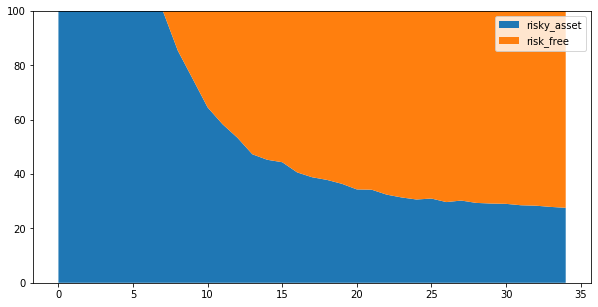

In [30]:
group_characherize_data = {"rho":-0.148281, "aggregate_risk":np.sqrt(0.219169+0.006102), 
                           "fixed_effect_coeff":[7.726381-3.200056+0.380076+0.080294*2], "age_coeff_list":[0.182626, -0.031862, 0.001874], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.726381-3.200056+0.380076+0.080294*2 + (25 * 0.182626 + ((25**2 /10) * -0.031862) + ((25**3/100) * 0.001874)))}

lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=6)

lc_weights_plot(lc_weights)

In [31]:
lc_weights

,risky_asset,risk_free
0,100.00,0.00
1,100.00,0.00
2,100.00,0.00
3,100.00,0.00
4,100.00,0.00
5,100.00,0.00
6,100.00,0.00
7,100.00,0.00
8,85.44,14.56
9,75.02,24.98


unemploy&high

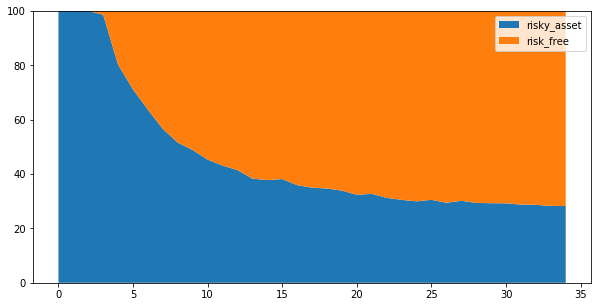

In [34]:
group_characherize_data = {"rho":0.522984, "aggregate_risk":np.sqrt(0.118801+0.009552), 
                           "fixed_effect_coeff":[7.492620-0.390035+0.330761+0.058637*2], "age_coeff_list":[-0.013523, 0.012117, -0.001289], 
                           "initial_wealth":10000, 
                           "initial_income":np.exp(7.492620-0.390035+0.330761+0.058637*2 + (25 * -0.013523 + ((25**2 /10) * 0.012117) + ((25**3/100) * -0.001289)))}

lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=6)

lc_weights_plot(lc_weights)